# 前日の値動きと当日の値動きの間の相関を探す
**単純かつ普遍的な傾向を見出すため、前日しか見ない。**

オープン・クローズ戦略のセットアップあるいはフィルターとして使うことを想定。

### 仮説
- 前日と当日の上昇・下落などに相関があるか

### 結論
- 詳細な調査はしていないが、おそらくあまり強い相関は無さそう。さすがに単純すぎるか。トレンドでフィルタリングすれば出るかもしれないが、それはあまり意味がないだろう。例えば上昇トレンドなら上昇している期間なのだから、その期間では`p(当日上昇 | 前日上昇)`が0.5を大きく超えるはずだがそれは当たり前のこと。
- ラリー・ウィリアムズの短期売買法には、**「トレーディングやシステム開発で最高の結果が得られたのは、ほとんどの場合、過去1日から過去4日間の平均を使った時だったのである。」**と書かれていたから、過去4日ぐらいまで見てみるのが良いかもしれない。

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import locale

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
df = pd.read_csv('./data/N225minif_2020_exchange_daily.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3377 entries, 0 to 3376
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日付      3377 non-null   object
 1   始値      3377 non-null   int64 
 2   高値      3377 non-null   int64 
 3   安値      3377 non-null   int64 
 4   終値      3377 non-null   int64 
 5   出来高     3377 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 158.4+ KB


,日付,始値,高値,安値,終値,出来高
0,2006/7/18,14680,14715,14400,14400,22345
1,2006/7/19,14500,14650,14465,14560,20646
2,2006/7/20,14860,14975,14780,14975,17398
3,2006/7/21,14840,14875,14790,14820,14689
4,2006/7/24,14685,14870,14560,14775,22641


# 1. 前日の値動きと当日の値動きの相関性
相関は見られない。わずかに逆相関があるのかも。とすれば、前日上がったら当日下がる可能性が高いということ。

### 以下のデータ加工方法だと日付が1日ずれているので注意！（ここでは日付情報を使っていないから問題ないが）

In [3]:
df['始値1'] = df['始値'][1:].append(pd.Series([np.nan])).reset_index(drop=True)
df['高値1'] = df['高値'][1:].append(pd.Series([np.nan])).reset_index(drop=True)
df['安値1'] = df['安値'][1:].append(pd.Series([np.nan])).reset_index(drop=True)
df['終値1'] = df['終値'][1:].append(pd.Series([np.nan])).reset_index(drop=True)

# ここでは、
# 前日：X値
# 当日：X値1
# として扱う

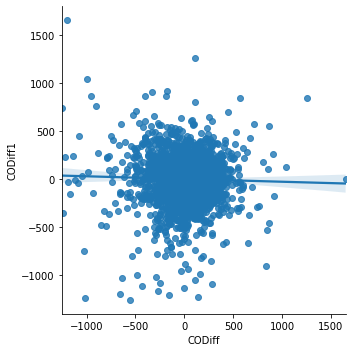

In [4]:
# 前日と当日それぞれの値動き
df['CODiff'] = df['終値'] - df['始値'] # 前日の値動き
df['CODiff1'] = df['終値1'] - df['始値1'] # 当日の値動き
sns.lmplot('CODiff', 'CODiff1', data=df)

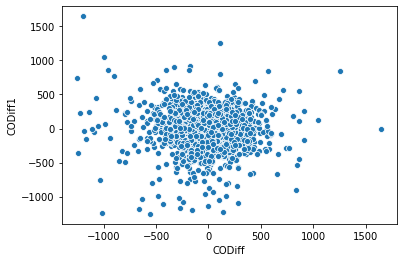

In [13]:
sns.scatterplot('CODiff', 'CODiff1', data=df)

In [6]:
# 前日上がった場合の当日の上昇確率
df_prev_up = df[df['CODiff'] > 0]
n_up = (df_prev_up['CODiff1'] > 0).sum()
print(f'前日上昇日数：{df_prev_up.shape[0]} のうち、当日上昇日数：{n_up}')
print(f'p( 当日上昇 | 前日上昇 ) = {100 * n_up / df_prev_up.shape[0]:.1f}%')

前日上昇日数：1760 のうち、当日上昇日数：897
p( 当日上昇 | 前日上昇 ) = 51.0%


In [7]:
# 前日X%以上上がった場合の当日の上昇確率を計算する関数
def up_days_when_up_x_percent_yesterday(x):
    df_prev_x_up = df[df['CODiff'] / (df['終値'] + df['始値']) * 2 > x]
    n_up = (df_prev_x_up['CODiff1'] > 0).sum()
    return n_up, df_prev_x_up.shape[0]

In [10]:
# 1%以上上昇
n_up_afer_1p, n_up_1p_total = up_days_when_up_x_percent_yesterday(0.01)
print(f'前日1%以上上昇日数：{n_up_1p_total} のうち、当日上昇日数：{n_up_afer_1p}')
print(f'p( 当日上昇 | 前日1%以上上昇 ) = {100 * n_up_afer_1p / n_up_1p_total:.1f}%')

前日1%以上上昇日数：671 のうち、当日上昇日数：348
p( 当日上昇 | 前日1%以上上昇 ) = 51.9%


In [11]:
# 2%以上上昇
n_up_afer_2p, n_up_2p_total = up_days_when_up_x_percent_yesterday(0.02)
print(f'前日2%以上上昇日数：{n_up_2p_total} のうち、当日上昇日数：{n_up_afer_2p}')
print(f'p( 当日上昇 | 前日2%以上上昇 ) = {100 * n_up_afer_2p / n_up_2p_total:.1f}%')

前日2%以上上昇日数：206 のうち、当日上昇日数：109
p( 当日上昇 | 前日2%以上上昇 ) = 52.9%


In [12]:
# 4%以上上昇
n_up_afer_4p, n_up_4p_total = up_days_when_up_x_percent_yesterday(0.04)
print(f'前日4%以上上昇日数：{n_up_4p_total} のうち、当日上昇日数：{n_up_afer_4p}')
print(f'p( 当日上昇 | 前日4%以上上昇 ) = {100 * n_up_afer_4p / n_up_4p_total:.1f}%')

前日4%以上上昇日数：29 のうち、当日上昇日数：15
p( 当日上昇 | 前日4%以上上昇 ) = 51.7%
